In [1]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

'\nPurpose: To Run the proofreading of neurons in the \ntest set and measure the precision and recall of the new rules\n\nSegments to look out for that had no axon\n864691135012395766 # one of the split segments files not there (split index = 1)\n864691135865584005 #soma soma merger\n864691136451113215 #it was an inhibitory neuron (part of split)\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-05-25 20:38:14,125 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-25 20:38:14,127 - settings - Setting database.user to celiib
INFO - 2021-05-25 20:38:14,128 - settings - Setting database.password to newceliipass
INFO - 2021-05-25 20:38:14,131 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-05-25 20:38:14,132 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-25 20:38:14,143 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-05-25 20:38:14,642 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-25 20:38:14,646 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-25 20:38:14,647 - settings - Setting database.user to celiib
INFO - 2021-05-25 20:38:14,647 - settings - Setting database.password to newceliipass
INFO - 2021-05-25 20:38:14,648 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-25 20:38:14,649 - settings - Setting database.user to celiib
INFO - 2021-05-25 20:38:14,650 - settings - Setting database.password to newceliipass
INFO - 2021-05-25 20:38:14,652 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-25 20:38:15,199 - settings - Setting enable_python_native_blobs to True


In [4]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-05-25 20:38:15,332 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-25 20:38:15,333 - settings - Setting database.user to celiib
INFO - 2021-05-25 20:38:15,334 - settings - Setting database.password to newceliipass
INFO - 2021-05-25 20:38:15,337 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-25 20:38:15,936 - settings - Setting enable_python_native_blobs to True


In [5]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

# Runnig the validation

In [ ]:
"""
Psueodocode: 
1) Pull down the segment ids of the valid neurons

For each neuron
1) Dwonload the neuron object
2) Run the Proofreading
3) Print out the validation plot
4) Save the validation df

"""

In [ ]:
"""
Pseudocode: 
1) Check if there are multiple somas associated with that segment

"""

In [ ]:
dj.U("segment_id") & (minnie.DecompositionAxon() 
                      & minnie.AutoProofreadValidationSegment4() - minnie.AutoProofreadValidationSegmentExclude4() )

In [ ]:
"""
Pseudocode: 
1) Find the coordinates of the nucleus for that new segment
2) Make sure that same number of DecompositionAxon objects as in Decomposition
3) Pick the neuron object that is closest and within a certain range of the nucleus
4) Download the neuron object
5) Run the proofreading
6) Save off the validation df
"""

In [ ]:
multi_soma_keys = (minnie.AutoProofreadValidationSegmentMap4() & "n_somas>1"
                      & minnie.DecompositionAxon.proj(old_segment_id="segment_id")).proj().fetch(as_dict=True)
key = multi_soma_keys[1]
key

verbose = True

segment_id = key["segment_id"]
print(f"\n-- Working on neuron {segment_id}---")

segment_map_dict = (minnie.AutoProofreadValidationSegmentMap4() & key).fetch1()

#1) Find the coordinates of the nucleus for that new segment
nucleus_id = segment_map_dict["nucleus_id"]
nuc_center_coords = du.nuclei_id_to_nucleus_centers(nucleus_id)
if verbose:
    print(f"nuc_center_coords = {nuc_center_coords}")

#2) Make sure that same number of DecompositionAxon objects as in Decomposition
old_segment_id = segment_map_dict["old_segment_id"]
if verbose:
    print(f"old_segment_id = {old_segment_id}")
    
search_key = dict(segment_id=old_segment_id)
n_somas = len(minnie.BaylorSegmentCentroid() & search_key)
n_decomp_axon = len(minnie.DecompositionAxon() & search_key)
if verbose:
    print(f"# of somas = {n_somas} and # of DecompositionAxon = {n_decomp_axon}")
    

if n_somas != n_decomp_axon:
    raise Exception(f"# of somas = {n_somas} NOT MATCH # of DecompositionAxon = {n_decomp_axon}")
    
#3) Pick the neuron object that is closest and within a certain range of the nucleus
neuron_objs,split_idxs = du.decomposition_with_spine_recalculation(old_segment_id)
if n_somas > 1:
    """
    Finding the closest soma:
    1) For each neuron object get the mesh center of the soma object
    2) Find the distance of each from the nucleus center
    3) Find the arg min distance and make sure within threshold
    4) Mark the current neuron and the current split index
    """
    nuclei_distance_threshold = 15000

    soma_center_coords = [k["S0"].mesh_center for k in neuron_objs]
    soma_distances = [np.linalg.norm(k-nuc_center_coords) for k in soma_center_coords]
    min_dist_arg = np.argmin(soma_distances)
    min_dist = soma_distances[min_dist_arg]

    if verbose:
        print(f"soma_distances = {soma_distances}")
        print(f"min_dist_arg = {min_dist_arg}, with min distance = {min_dist}")

    if min_dist > nuclei_distance_threshold:
        raise Exception(f"min_dist ({min_dist}) larger than nuclei_distance_threshold ({nuclei_distance_threshold})")

    neuron_obj = neuron_objs[min_dist_arg]
    split_index = split_idxs[min_dist_arg]

    if verbose:
        print(f"Winning split_index = {split_index}")
else:
    split_index = split_idxs[0]
    neuron_obj = neuron_objs[0]
    
    
import proofreading_utils as pru
import validation_utils as vu
(filt_neuron,
     return_synapse_df_revised,
     return_synapse_df_errors,
    return_validation_df_revised,
    return_validation_df_extension) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v4_exc_filters(),
                        plot_limb_branch_filter_with_disconnect_effect = True,
                        verbose = True,
                        plot_score=False,
                        nucleus_id = nucleus_id,
                        return_synapse_df_errors=True,
                        return_validation_df_extension = True,                                        
                        split_index=split_index)
    

In [ ]:
vu.synapse_validation_df_to_score_plot(return_validation_df_revised)

In [ ]:
nviz.plot_axon(filt_neuron)

In [ ]:
import neuron_visualizations as nviz
nviz.visualize_neuron(filt_neuron,
                      limb_branch_dict="all")

In [ ]:
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.15,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

# Trial 2

In [ ]:
multi_soma_keys = (minnie.AutoProofreadValidationSegmentMap4() & "n_somas>1"
                      & minnie.DecompositionAxon.proj(old_segment_id="segment_id")).proj().fetch(as_dict=True)
key = multi_soma_keys[1]
key

In [ ]:
minnie.DecompositionAxon.proj(old_segment_id="segment_id") & (dj.U("old_segment_id") &
                                                              (minnie.AutoProofreadValidationSegmentMap4() & "n_somas>1"))

In [ ]:
nviz.visualize_neuron_specific_limb(neuron_obj,
                                   1)

In [ ]:
nviz.visualize_neuron(neuron_obj,
                     limb_branch_dict="all")

In [ ]:
# import classification_utils as clu
# clu.axon_classification(neuron_obj,
#                         plot_candidates=True,
#                        plot_axons=True,
#                             verbose=True,
#                         plot_axon_like_segments=True
#                            )

In [ ]:
nviz.plot_axon(neuron_obj)

In [ ]:
minnie.AutoProofreadValidationSegmentMap4() & dict(old_segment_id=864691135373402824
                                                  )

In [ ]:
minnie.AutoProofreadValidationSegmentMap4.describe()

In [ ]:
filt_neuron.segment_id

In [ ]:
multi_soma_keys = (minnie.AutoProofreadValidationSegmentMap4() & "n_somas>1"
                      & minnie.DecompositionAxon.proj(old_segment_id="segment_id")).proj().fetch(as_dict=True)
key = multi_soma_keys[1]
key = [k for k in multi_soma_keys if k["segment_id"] == 864691136023980601][0]

verbose = True

segment_id = key["segment_id"]
print(f"\n-- Working on neuron {segment_id}---")

segment_map_dict = (minnie.AutoProofreadValidationSegmentMap4() & key).fetch1()

#1) Find the coordinates of the nucleus for that new segment
nucleus_id = segment_map_dict["nucleus_id"]
nuc_center_coords = du.nuclei_id_to_nucleus_centers(nucleus_id)
if verbose:
    print(f"nuc_center_coords = {nuc_center_coords}")

#2) Make sure that same number of DecompositionAxon objects as in Decomposition
old_segment_id = segment_map_dict["old_segment_id"]
if verbose:
    print(f"old_segment_id = {old_segment_id}")
    
search_key = dict(segment_id=old_segment_id)
n_somas = len(minnie.BaylorSegmentCentroid() & search_key)
n_decomp_axon = len(minnie.DecompositionAxon() & search_key)
if verbose:
    print(f"# of somas = {n_somas} and # of DecompositionAxon = {n_decomp_axon}")
    

if n_somas != n_decomp_axon:
    raise Exception(f"# of somas = {n_somas} NOT MATCH # of DecompositionAxon = {n_decomp_axon}")
    
#3) Pick the neuron object that is closest and within a certain range of the nucleus
neuron_objs,split_idxs = du.decomposition_with_spine_recalculation(old_segment_id)
if n_somas > 1:
    """
    Finding the closest soma:
    1) For each neuron object get the mesh center of the soma object
    2) Find the distance of each from the nucleus center
    3) Find the arg min distance and make sure within threshold
    4) Mark the current neuron and the current split index
    """
    nuclei_distance_threshold = 15000

    soma_center_coords = [k["S0"].mesh_center for k in neuron_objs]
    soma_distances = [np.linalg.norm(k-nuc_center_coords) for k in soma_center_coords]
    min_dist_arg = np.argmin(soma_distances)
    min_dist = soma_distances[min_dist_arg]

    if verbose:
        print(f"soma_distances = {soma_distances}")
        print(f"min_dist_arg = {min_dist_arg}, with min distance = {min_dist}")

    if min_dist > nuclei_distance_threshold:
        raise Exception(f"min_dist ({min_dist}) larger than nuclei_distance_threshold ({nuclei_distance_threshold})")

    neuron_obj = neuron_objs[min_dist_arg]
    split_index = split_idxs[min_dist_arg]

    if verbose:
        print(f"Winning split_index = {split_index}")
else:
    split_index = split_idxs[0]
    neuron_obj = neuron_objs[0]
    
import proofreading_utils as pru
import validation_utils as vu
(filt_neuron,
     return_synapse_df_revised,
     return_synapse_df_errors,
    return_validation_df_revised,
    return_validation_df_extension) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v4_exc_filters(),
                        plot_limb_branch_filter_with_disconnect_effect = True,
                        verbose = True,
                        plot_score=False,
                        nucleus_id = nucleus_id,
                        return_synapse_df_errors=True,
                        return_validation_df_extension = True,                                        
                        split_index=split_index)
    

In [ ]:
return_validation_df_revised[return_validation_df_revised["synapse_id"]==372205515]

In [ ]:
filt_neuron.description

In [ ]:
minnie.AutoProofreadValidationScore4()#.fetch("validation_df")

In [ ]:
curr_table = (minnie.schema.jobs & "table_name='__auto_proofread_validation_score4'")
(curr_table)#.delete()

In [ ]:
minnie.AutoProofreadValidationSegmentMap4() & "segment_id=864691136105661657"

In [ ]:
neuron_obj = du.decomposition_with_spine_recalculation(864691136740414556,0)

In [ ]:
nviz.plot_axon(neuron_obj)

In [9]:
minnie.AutoProofreadValidationSegmentMap4() & dict(segment_id=864691135367284729)

INFO - 2021-05-26 01:04:07,846 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 01:04:07,867 - settings - Setting database.user to celiib
INFO - 2021-05-26 01:04:07,868 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 01:04:07,882 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 01:04:09,091 - settings - Setting enable_python_native_blobs to True


ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,old_segment_id the segment id in the proofread version--,finished_dendrite whether axon was finished cleaning,finished_axon whether axon was finished cleaning,extension_type,n_somas,n_soma_mergers,n_glia,large_splits,notes
88.00,610615,864691135367284729,0.08,864691136664412413,True,True,partial,2,0,0,0,half soma merge


In [ ]:
print((curr_table & "key_hash='40a99bace81e99ae6d791efba1a4c8a1'").fetch1("error_stack"))

In [6]:
minnie,_ = du.configure_minnie_vm()
validation_dfs = minnie.AutoProofreadValidationScore4().fetch("validation_df")
validation_dfs = [vu.load_df_val_from_numpy(k) for k in validation_dfs]
validation_dfs

INFO - 2021-05-25 20:38:29,080 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-25 20:38:29,081 - settings - Setting database.user to celiib
INFO - 2021-05-25 20:38:29,081 - settings - Setting database.password to newceliipass
INFO - 2021-05-25 20:38:29,085 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-25 20:38:29,753 - settings - Setting enable_python_native_blobs to True


[     synapse_id synapse_type auto_valid synapse_x synapse_y synapse_z  \
 0      76963424       presyn       True    521800    532392    972400   
 1      76963829       presyn       True    523416    531720    972240   
 2      76964110       presyn       True    524512    532600    972680   
 3      78899369       presyn       True    534080    501888    975520   
 4      78899421       presyn       True    534352    501976    975760   
 ...         ...          ...        ...       ...       ...       ...   
 5503  117704562      postsyn      False    612136    502816   1005040   
 5504  117704639      postsyn      False    612600    502936   1005600   
 5505  117704984      postsyn      False    614240    498816   1006840   
 5506  121682236      postsyn      False    622088    517176   1012840   
 5507  137292646      postsyn      False    659096    515676    926400   
 
      manual_valid category      old_segment_id      new_segment_id  \
 0            True       TP  8646911355

In [7]:
import pandas_utils as pu
total_validation_df = pu.concat(validation_dfs)
total_validation_df

,synapse_id,synapse_type,auto_valid,synapse_x,synapse_y,synapse_z,manual_valid,category,old_segment_id,new_segment_id,euclidean_distance_to_nuclei
0,76963424,presyn,True,521800,532392,972400,True,TP,864691135585319036,864691135855890478,76638.6
1,76963829,presyn,True,523416,531720,972240,True,TP,864691135585319036,864691135855890478,75006.3
2,76964110,presyn,True,524512,532600,972680,True,TP,864691135585319036,864691135855890478,74918.2
3,78899369,presyn,True,534080,501888,975520,False,FP,864691135585319036,864691135855890478,49643.6
4,78899421,presyn,True,534352,501976,975760,False,FP,864691135585319036,864691135855890478,49517.3
...,...,...,...,...,...,...,...,...,...,...,...
5357,481632172,postsyn,False,1473224,695480,749840,True,FN,864691136056340440,864691135724393131,68025.8
5358,481632213,postsyn,False,1473840,695184,749120,True,FN,864691136056340440,864691135724393131,68850
5359,481632269,postsyn,False,1473888,696528,747480,True,FN,864691136056340440,864691135724393131,69491.1
5360,481632479,postsyn,False,1475160,697832,747160,True,FN,864691136056340440,864691135724393131,70829.3


Segment Id = 864691134988385914
Postsyn counts:
TP:484041
TN:113806
FP:7026
FN:11761
Presyn counts:
TP:2417
TN:25333
FP:695
FN:840


WARNING - 2021-05-25 20:40:05,780 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2021-05-25 20:40:05,797 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2021-05-25 20:40:05,802 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


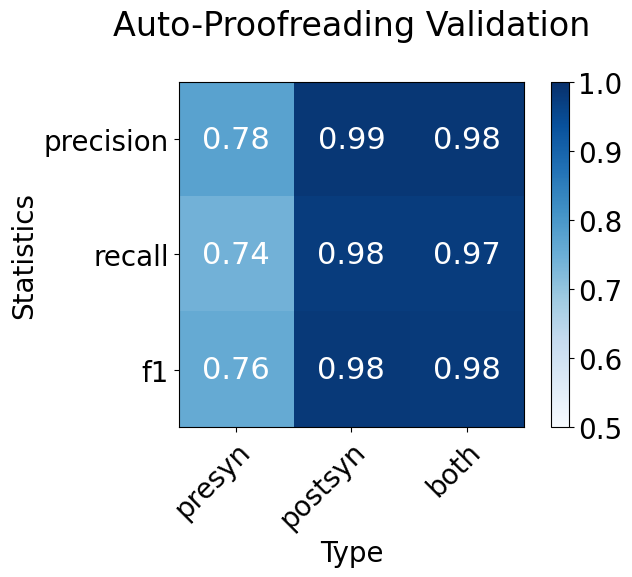

In [8]:
vu.synapse_validation_df_to_score_plot(total_validation_df)

In [ ]:
presyn_scores_dict = vu.scores_presyn(return_validation_df_revised)
postsyn_scores_dict = vu.scores_postsyn(return_validation_df_revised)

presyn_scores_dict,postsyn_scores_dict

In [ ]:
vu.synapse_validation_df_to_score_df(return_validation_df_revised)

In [ ]:
vu.synapse_validation_df_to_category_counts(return_validation_df_revised,
                                            print_postsyn=True,
                                            print_presyn=False)

In [ ]:
[k for k in dir(vu) if "coor" in k]

In [ ]:
FP_presyn = return_validation_df_revised[(return_validation_df_revised["synapse_type"] == "presyn") & 
(return_validation_df_revised["category"] == "FP")]
FP_presyn_coord = vu.validation_df_to_coordinates(FP_presyn)

nviz.plot_objects(filt_neuron.mesh,
                 scatters=[FP_presyn_coord],
                 scatter_size=0.1)

In [ ]:
minnie.AutoProofreadValidationScore

In [ ]:
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.15,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

In [ ]:
for seg_id in segments_to_process:
    print(f"\n--- Working on Neuron {seg_id} --")
    st = time.time()
    
    
    #1) Dwonload the neuron object
    neuron_obj = du.fetch_neuron_obj_manual(seg_id,
                                       border_validation=True)
    
    (filt_neuron,
     return_synapse_df_revised,
    return_validation_df_revised) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v4_exc_filters(),
                        plot_limb_branch_filter_with_disconnect_effect = False,
                        verbose = False,
                        plot_score=False)
    
    vu.synapse_validation_df_to_score_plot(return_validation_df_revised)
    
    su.compressed_pickle(return_validation_df_revised,f"./validation_data/{seg_id}_validation_df")
    
    print(f"Total time for neuron {seg_id}: {time.time() - st}")